In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
# # of states except for terminal states
N_STATES = 19

# all states
STATES = np.arange(0, N_STATES)

# start from a central state
START_STATE = 9

# terminal states
END_STATES = [0, N_STATES - 1]

# possible actions
ACTION_LEFT = -1
ACTION_RIGHT = 1
ACTIONS = [ACTION_LEFT, ACTION_RIGHT]

# maximum stride for an action
STEP_RANGE = 1

def step(state, action):
    if action > 0 :
        action = 1
    elif action < 0:
        action = -1
    step = np.random.randint(1, STEP_RANGE + 1)
    step *= action
    state += step
    state = max(min(state, N_STATES - 1), 0)
    if state == 0:
        reward = -1
    elif state == N_STATES - 1:
        reward = 1
    else:
        reward = 0
    return state, reward

def make_epsilon_greedy_policy(Q, nA, epsilon):

    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon/nA
        best_action = np.argmax(Q[observation])
        A[best_action] += ( 1.0 - epsilon)
        return A

    return policy_fn

def compute_RMS_error(Q,V):
    ans = 0.0
    for i in range(len(V)):
        ans += ((Q[i][0] + Q[i][1])/2 - V[i]) ** 2
    ans = np.sqrt(ans/len(Q))
    return ans

In [2]:
T = 1000
n = 3
alpha = 0.4
sigma = 0.25
Q = defaultdict(lambda: np.zeros(2))
behavior_policy = make_epsilon_greedy_policy(Q, len(ACTIONS),epsilon = 1)
target_policy = make_epsilon_greedy_policy(Q, len(ACTIONS),epsilon = 1)
gamma = 1.0
discount_sigma = 0.8
v = np.arange(-1+1/9 ,1 ,1/9)
v = [0.0] + list(v) + [0.0]

In [3]:
def Q_sigma(num_episodes, sigma, b_pi, t_pi):
    d_sigma = False
    if sigma == -1 :
        d_sigma = True
    Q = defaultdict(lambda : np.zeros(len(ACTIONS)))
    RMSE = []
    for i_episode in range(num_episodes):
        if d_sigma :
#             sigma =  1.0 - (i_episode/(num_episodes-1))
            sigma = discount_sigma ** i_episode
        actions = []
        states = []
        deltas = []
        pis = []
        Qs = []
        ps = []
        state = START_STATE
        action_probs = b_pi(state)
        action = np.random.choice(np.arange(len(action_probs)), p = action_probs)
        
        states.append(state)
        actions.append(action)
        pis.append(action_probs[action])
        Qs.append(Q[state][action])
        ps.append(t_pi(state)[action]/b_pi(state)[action])
        
        # step within each episode
        final_time = 0
        done = False
        for t in range(T) :
            
            next_state, reward = step(state,(action-0.5)*2)
            states.append(next_state)
            if next_state in END_STATES:
                deltas.append(reward - Q[state][action])
                done = True
            else : 
                # Select next action
                next_action_probs = t_pi(next_state)
                next_action = np.random.choice(np.arange(len(next_action_probs)), p = next_action_probs)

                # Store
                actions.append(next_action)
                Qs.append(Q[next_state][next_action])
                pis.append(b_pi(next_state)[next_action])
                V_next = next_action_probs[0] * Q[next_state][0] + next_action_probs[1] * Q[next_state][1]
                deltas.append(reward + gamma*(sigma*Q[next_state][next_action] + (1-sigma)*V_next) - Q[state][action])
                action = next_action
                state = next_state
                ps.append(t_pi(next_state)[next_action]/b_pi(next_state)[next_action])
                
            # Update within each step
            tau = t - n + 1
            if tau >= 0:
                p = 1.0
                E = 1.0
                G = Q[states[tau]][actions[tau]]
                for k in range(tau,t+1):
                    G = G + E*deltas[k]
                    E = gamma*E*((1-sigma)*pis[k] + sigma)
                    p = p*(1-sigma + sigma*ps[k])
                Q[states[tau]][actions[tau]] += alpha*p*(G - Q[states[tau]][actions[tau]])
            if done :
                break
        for i in range(t-n+1,t+1):
            p = 1.0
            E = 1.0
            G = Q[states[i]][actions[i]]
            for k in range(i,t+1):
                G = G + E*deltas[k]
                E = gamma*E*((1-sigma)*pis[k] + sigma)
                p = p*(1-sigma + sigma*ps[k])
            Q[states[i]][actions[i]] += alpha*p*(G - Q[states[i]][actions[i]])
        RMSE.append(compute_RMS_error(Q,v))
    return Q,RMSE

In [4]:
a1 = []
a2 = []
a3 = []
a4 = []
a5 = []
a6 = []
episode = 50
for i in range(10):
#     print(i)
    _ ,RMSE_1 = Q_sigma(episode,1,behavior_policy,target_policy)
    _ ,RMSE_075 = Q_sigma(episode,0.75,behavior_policy,target_policy)
    _ ,RMSE_05 = Q_sigma(episode,0.5,behavior_policy,target_policy)
    _ ,RMSE_025 = Q_sigma(episode,0.25,behavior_policy,target_policy)
    _ ,RMSE_0 = Q_sigma(episode,0,behavior_policy,target_policy)
    _ ,RMSE_d = Q_sigma(episode,-1,behavior_policy,target_policy)
    a1.append(RMSE_1)
    a2.append(RMSE_075)
    a3.append(RMSE_05)
    a4.append(RMSE_025)
    a5.append(RMSE_0)
    a6.append(RMSE_d)
RMSE_1 = [0.0] * len(a1[0])
RMSE_075 = [0.0] * len(a1[0])
RMSE_05 = [0.0] * len(a1[0])
RMSE_025 = [0.0] * len(a1[0])
RMSE_0 = [0.0] * len(a1[0])
RMSE_d = [0.0] * len(a1[0])
for j in range(len(a1[0])):
    for i in range(len(a1)):
        RMSE_1[j] += a1[i][j]
        RMSE_075[j] += a2[i][j]
        RMSE_05[j] += a3[i][j]
        RMSE_025[j] += a4[i][j]
        RMSE_0[j] += a5[i][j]
        RMSE_d[j] += a6[i][j]
    RMSE_1[j] /= len(a1)
    RMSE_075[j] /= len(a1)
    RMSE_05[j] /= len(a1)
    RMSE_025[j] /= len(a1)
    RMSE_0[j] /= len(a1)
    RMSE_d[j] /= len(a1)

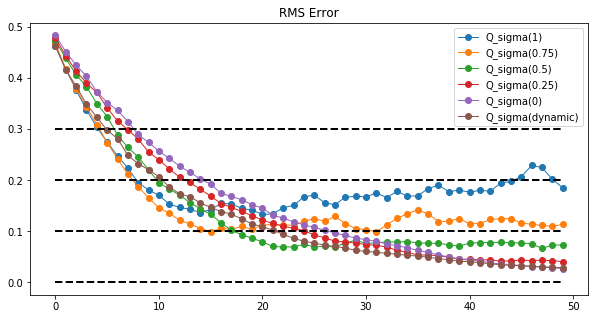

In [5]:

df=pd.DataFrame({'x': range(len(RMSE_1)),
                 'Q_sigma(1)': RMSE_1, 
                 'Q_sigma(0.75)': RMSE_075,
                 'Q_sigma(0.5)': RMSE_05,
                 'Q_sigma(0.25)': RMSE_025,
                 'Q_sigma(0)': RMSE_0,
                 'Q_sigma(dynamic)': RMSE_d,
                })

plt.figure(figsize=(10*len(RMSE_1)/episode,5))
plt.title('RMS Error')
plt.plot( 'x', 'Q_sigma(1)', data=df, marker='o',linewidth=1, label="Q_sigma(1)")
plt.plot( 'x', 'Q_sigma(0.75)', data=df, marker='o',  linewidth=1, label="Q_sigma(0.75)")
plt.plot( 'x', 'Q_sigma(0.5)', data=df, marker='o',linewidth=1, label="Q_sigma(0.5)")
plt.plot( 'x', 'Q_sigma(0.25)', data=df, marker='o',linewidth=1, label="Q_sigma(0.25)")
plt.plot( 'x', 'Q_sigma(0)', data=df, marker='o',linewidth=1, label="Q_sigma(0)")
plt.plot( 'x', 'Q_sigma(dynamic)', data=df, marker='o',linewidth=1, label="Q_sigma(dynamic)")
plt.plot( range(len(RMSE_1)), [0]*len(RMSE_1),linestyle = '--',color = 'black',linewidth=2)
plt.plot( range(len(RMSE_1)), [0.1]*len(RMSE_1),linestyle = '--',color = 'black',linewidth=2)
plt.plot( range(len(RMSE_1)), [0.2]*len(RMSE_1),linestyle = '--',color = 'black',linewidth=2)
plt.plot( range(len(RMSE_1)), [0.3]*len(RMSE_1),linestyle = '--',color = 'black',linewidth=2)
plt.legend()
